# 미니프로젝트: 나만의 딥러닝 모델로 Mnist Dataset 학습하기
## <0-9 숫자 손글씨 인식 문제>

## 1. 패키지 불러오기 및 GUI 프로그램 작성

In [1]:
import os

# matplotlib 패키지 결과물을 노트북 실행 
# 브라우저 안에 보일 수 있게 하는 명령어
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader

# mnist 내장된 torchvision 패키지에서 데이터셋 불러오기
from torchvision import datasets, transforms

# 손글씨 써볼 수 있는 GUI 프로그램
""" 제공된 drawing.py 이용!! """
from drawing import Drawing
# 그림 시각화 처리 패키지
import matplotlib.pyplot as plt
from PIL import Image

def drawing_custom_number(preprocess, filepath="./figs", return_img=True):
    """ 손글씨 입력 GUI 미니 프로그램 """
    if (not os.path.isdir("figs")) and (filepath == "./figs"):
        os.mkdir("figs")
    draw = Drawing()
    draw.main(preprocess=preprocess, filepath=filepath)
    img = Image.open(draw.file)
    plt.imshow(img, cmap='gray')
    plt.show()
    if return_img:
        return img

## 2. 데이터 살펴보기

Target: 0
Size of Image: (28, 28)


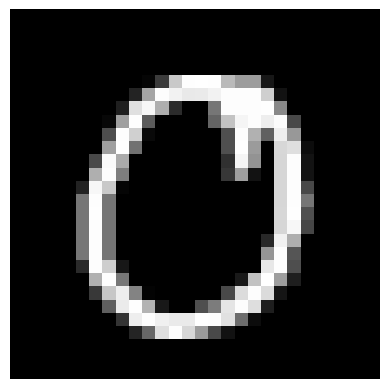

In [2]:
torch.manual_seed(70)

train_dataset = datasets.MNIST(root='./data', # 데이터 경로
                              train=True,     # 훈련데이터 여부
                              download=True,  # 기존에 없으면 root경로에 다운로드
                              transform=transforms.ToTensor()) # 텐서로 바꾸는 전처리

test_dataset = datasets.MNIST(root='./data',
                             train=False,
                             transform=transforms.ToTensor())

# 데이터 살펴보기: 훈련데이터 중 임의의 데이터 골라서 보여줌
idx = torch.randint(0, len(train_dataset), (1,)).item()
random_image = train_dataset[idx][0].squeeze().numpy()
target_num = train_dataset[idx][1]
print("Target: {}".format(target_num))
print("Size of Image: {}".format(random_image.shape))
plt.imshow(random_image, cmap='gray')
plt.axis('off')
plt.show()

## [MNIST Dataset]
- 인공지능 연구 권위자 LeCun 교수님께서 만드심.
- 딥러닝을 공부할 때 반드시 거쳐야하는 존재
- 6만개의 학습데이터, 1만개의 검증데이터
- 간단한 컴퓨터 비전 데이터 세트
- 0~1 정규화된 28\*28 픽셀, 중앙 정렬
- 각 이미지는 평평하게 784 feature의 1D numpy 배열로 변환됨.

## 3. 데이터로더 정의하기

In [3]:
BATCH = 64
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
STEP = 10

train_loader = DataLoader(dataset=train_dataset,
                         batch_size=BATCH,
                         shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=BATCH,
                        shuffle=True)

for (data, target) in train_loader:
    print(data.size(), target.size(), sep='\n')
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


## 4. 모델, 손실함수 및 옵티마이저 정의

In [4]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.flatten = lambda x: x.view(x.size(0), -1)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)        
        self.linear3 = nn.Linear(hidden_size, output_size)        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x

### 4-1. 모델 선언

In [5]:
model = Net(input_size=28*28, hidden_size=100, output_size=10).to(DEVICE)
# .to(DEVICE): 'cuda' 혹은 'cpu' 문자열을 모델에게 전달해서, GPU 사용 여부 결정

### 4-2. 손실함수, 옵티마이저 선언

In [6]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# 매개변수 개수 확인
num_params = 0
for params in model.parameters():
    num_params += params.view(-1).size(0)
print("Total number of parameters: {}".format(num_params))

Total number of parameters: 89610


## 5. 학습 및 테스트

In [7]:
def train(model, train_loader, loss_func, optimizer, step, device, print_step=200):
    """ 1스텝 동안 발생하는 학습과정 """
    
    # 모델에게 훈련단계라고 선언
    model.train()
    
    for batch_idx, (data,target) in enumerate(train_loader):
        # 1) 입력과 타겟 텐서에 GPU 사용여부 전달
        data, target = data.to(device), target.to(device)
        # 2) 경사 초기화
        model.zero_grad()
        # 3) 순방향 전파
        output = model(data)
        # 4) 손실값 계산
        loss = loss_func(output, target)
        # 5) 역방향 전파
        loss.backward()
        # 6) 매개변수 업데이트
        optimizer.step()
        
        # 중간과정 print
        if batch_idx % print_step == 0:
            print("Train Step: {} ({:05.2f}%)  \tLoss: {:.4f}".format(step,
            100.*(batch_idx*train_loader.batch_size)/len(train_loader.dataset),
                                                                loss.item()))
            
def test(model, test_loader, loss_func, device):
    # 모델에게 평가단계라고 선언
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data,target in test_loader:
            data, target = data.to(device), target.to(device)
            # 1) 순방향전파
            output = model(data)
            # 2) 손실 계산 (합)
            test_loss += loss_func(output, target, reduction='sum').item()
            # 3) 예측값에 해당하는 클래스 번호 반환
            pred = output.softmax(1).argmax(dim=1, keepdim=True)
            # 4) 정확하게 예측한 개수 기록
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_acc = correct / len(test_loader.dataset)
    
    print("Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:05.2f}%)".format(\
        test_loss, correct, len(test_loader.dataset), 100.*test_acc))
    
    return test_loss, test_acc

def main(model, train_loader, test_loader, loss_func, optimizer, n_step, device,
        save_path=None, print_step=200):
    """ 메인 학습 함수 """
    test_accs = []
    best_acc = 0.0
    
    for step in range(1, n_step+1):
        # 훈련
        train(model, train_loader, loss_func, optimizer,
             step=step, device=device, print_step=print_step)
        # 평가
        test_loss, test_acc = test(model, test_loader,
                                  loss_func = F.cross_entropy,
                                  device=device)
        
        # 테스트 정확도 기록
        test_accs.append(test_acc)
        
        # 모델 최적의 매개변수값을 저장할지 결정하고, 기록
        if len(test_accs) >= 2:
            if test_acc >= best_acc:
                best_acc = test_acc
                best_state_dict = model.state_dict()
                print("discard previous state, best model state saved!")
        print("")
        
    # 매개변수 값 저장
    if save_path is not None:
        torch.save(best_state_dict, save_path)

### 학습 시작

In [8]:
main(model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_func=loss_function,
    optimizer=optimizer,
    n_step=STEP,
    device=DEVICE,
    save_path="mnist_model.pt",
    print_step=200)

Train Step: 1 (00.00%)  	Loss: 2.3013
Train Step: 1 (21.33%)  	Loss: 0.2655
Train Step: 1 (42.67%)  	Loss: 0.3571
Train Step: 1 (64.00%)  	Loss: 0.2010
Train Step: 1 (85.33%)  	Loss: 0.2346
Test set: Average loss: 0.1893, Accuracy: 9419/10000 (94.19%)

Train Step: 2 (00.00%)  	Loss: 0.0604
Train Step: 2 (21.33%)  	Loss: 0.1508
Train Step: 2 (42.67%)  	Loss: 0.0415
Train Step: 2 (64.00%)  	Loss: 0.0584
Train Step: 2 (85.33%)  	Loss: 0.2859
Test set: Average loss: 0.1229, Accuracy: 9624/10000 (96.24%)
discard previous state, best model state saved!

Train Step: 3 (00.00%)  	Loss: 0.1770
Train Step: 3 (21.33%)  	Loss: 0.1353
Train Step: 3 (42.67%)  	Loss: 0.0814
Train Step: 3 (64.00%)  	Loss: 0.0401
Train Step: 3 (85.33%)  	Loss: 0.1208
Test set: Average loss: 0.1033, Accuracy: 9685/10000 (96.85%)
discard previous state, best model state saved!

Train Step: 4 (00.00%)  	Loss: 0.0458
Train Step: 4 (21.33%)  	Loss: 0.0174
Train Step: 4 (42.67%)  	Loss: 0.1234
Train Step: 4 (64.00%)  	Loss: 

# 6. 내가 그린 손글씨로 테스트

file saved ./figs\num_img.png


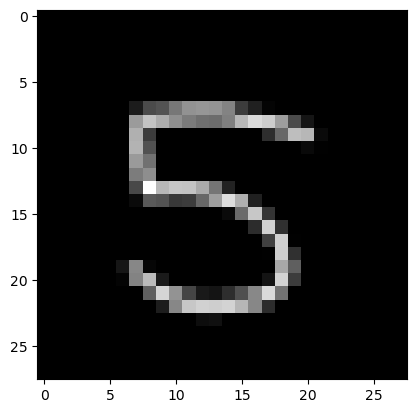

In [9]:
img = drawing_custom_number(preprocess=True, return_img=True)

In [10]:
# 내가 그린 이미지를 (1,28,28) 크기 텐서로 바꿔줌
test_input = torch.Tensor(np.array(img)).unsqueeze(0).to(DEVICE)
pred = model(test_input)
print("Predicted number is {}.".format(pred.softmax(1).argmax().item()))

Predicted number is 5.


In [11]:
pred

tensor([[ -955.0872, -1143.5399,  -857.5981,   250.9672, -1120.6174,   597.0349,
         -1418.8156,  -919.2238,    23.1948,   453.6948]],
       grad_fn=<AddmmBackward0>)

In [17]:
pred.softmax(1)

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>)

In [18]:
img